### Portfolio Optimization using Deep Learning 

#### Implementation and modification of [this paper](https://arxiv.org/pdf/2005.13665). 

#### Modifications will include:
1. Use of different recursive networks (Transformer, GRU, LSTM)
2. Hyperparameter optimization
3. Additional input features
4. Loss function comparison between Sharpe and Sortino

Imports

In [14]:
import yfinance as yf 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb
from scipy.stats import kurtosis, skew, jarque_bera
from sklearn.preprocessing import StandardScaler
import scipy.optimize as opt
from stats import get_rolling_correlations
from model import TransformerModel, train_model
from sharpe import optimize_portfolio

In our analysis, we will build a simple portfolio of 4 indices:
1. AGG (Agg. Bond ETF)
2. DBC (Commodity Index)
3. VTI (Vanguard Total Stock Index)
4. VIX (CBOE Volatility Index)

Build dataframe

In [5]:
ETFS = ['AGG','DBC','VTI', '^VIX']
START_DATE = '2010-01-01'
END_DATE ='2025-01-01'

etf_df = pd.DataFrame(columns=ETFS)

for etf in ETFS:
    # fetch ticker
    ticker = yf.Ticker(etf)
    new_col = ticker.history(start=START_DATE, end=END_DATE)['Close']

    # fix timezone
    new_col.index = new_col.index.tz_localize(None)
    etf_df[etf] = new_col

etf_df.head()

,AGG,DBC,VTI,^VIX
Date,,,,
2010-01-04,68.257156,22.057026,43.594379,20.040001
2010-01-05,68.567741,22.083244,43.761715,19.350000
2010-01-06,68.528084,22.476492,43.822571,19.160000
2010-01-07,68.448769,22.196848,44.005131,19.059999
2010-01-08,68.488434,22.179369,44.149658,18.129999


Quick plot

<Axes: xlabel='Date'>

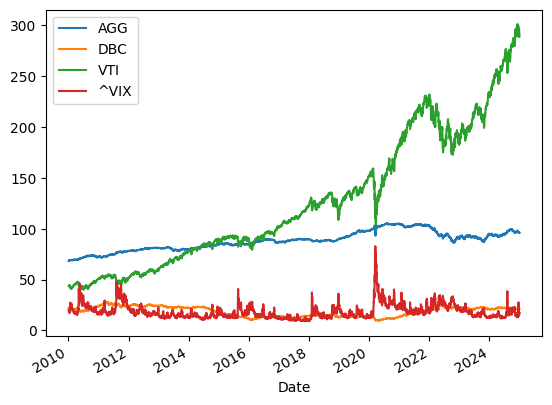

In [6]:
etf_df.plot()

Pairs Correlation

             AGG-DBC   AGG-VTI  AGG-^VIX   DBC-VTI  DBC-^VIX  VTI-^VIX
Date                                                                  
2010-03-16 -0.657845  0.041335  0.001425  0.653206 -0.645762 -0.919891
2010-03-17 -0.597513  0.143939 -0.065134  0.635893 -0.649275 -0.919906
2010-03-18 -0.551363  0.221913 -0.127488  0.620192 -0.646798 -0.921383
2010-03-19 -0.505085  0.287688 -0.183531  0.614829 -0.654298 -0.922891
2010-03-22 -0.442002  0.372942 -0.248367  0.595140 -0.657289 -0.923320


<Axes: xlabel='Date'>

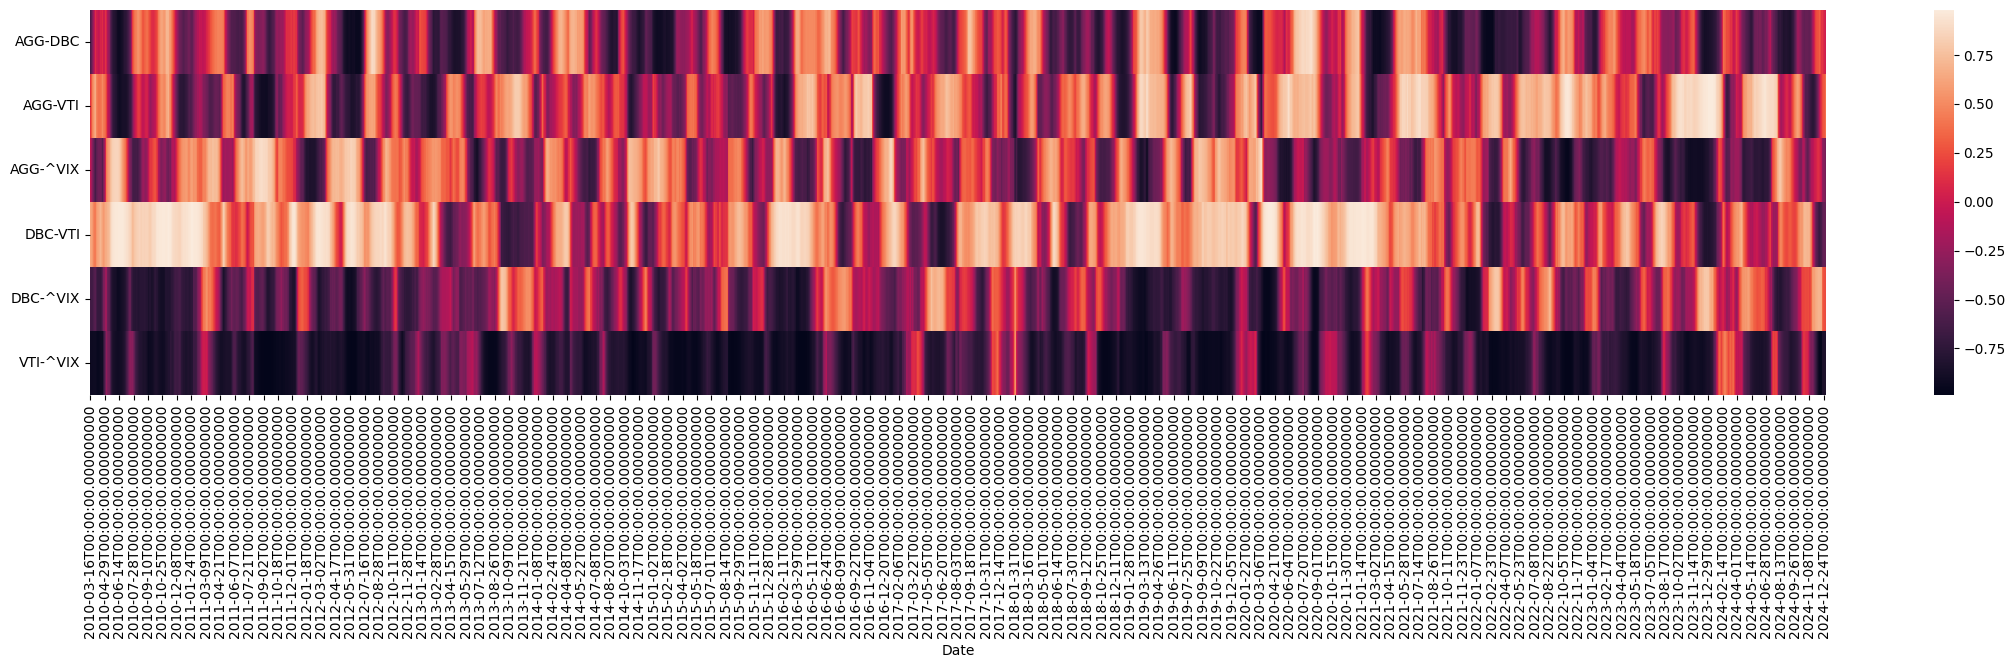

In [7]:
rolling_cors = get_rolling_correlations(etf_df)
fig, ax = plt.subplots(1,1, figsize=(28,5))
sb.heatmap(rolling_cors.transpose())

Plot the returns for each pair

                 AGG       DBC       VTI      ^VIX
Date                                              
2010-01-05  0.004550  0.001189  0.003838 -0.034431
2010-01-06 -0.000578  0.017808  0.001391 -0.009819
2010-01-07 -0.001157 -0.012442  0.004166 -0.005219
2010-01-08  0.000579 -0.000787  0.003284 -0.048793
2010-01-11 -0.000771 -0.003152  0.001378 -0.031991


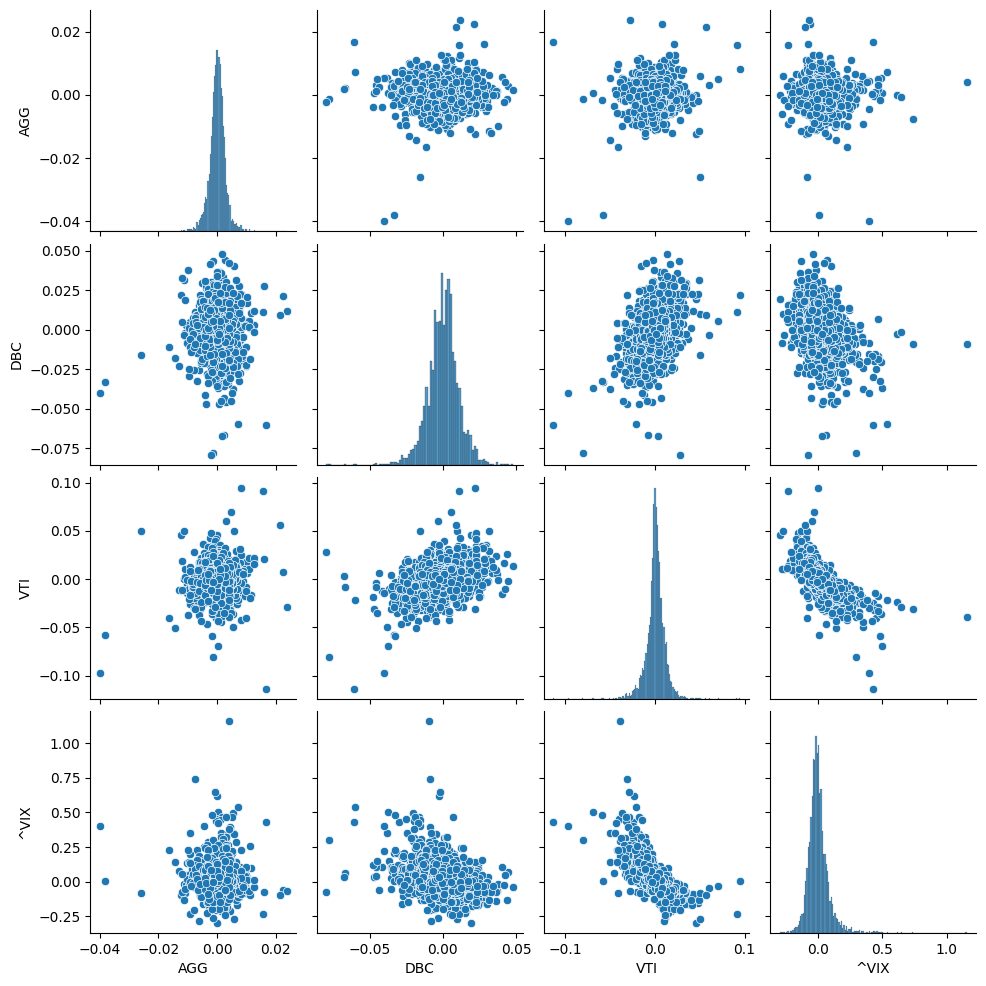

In [8]:
returns = etf_df.pct_change()[1:].fillna(0)
print(returns.head())
sb.pairplot(returns)

Check distribution of returns

In [9]:
print("Kurtosis: ", kurtosis(returns))
print("Skewness: ", skew(returns))

Kurtosis:  [21.34921611  3.72277726 11.10743436 17.63541483]
Skewness:  [-1.07321549 -0.55614616 -0.51480304  2.29858005]


In [10]:
for i in returns.columns:
    _, p_value = jarque_bera(returns[i])
    print("Normality test of " + i + " return: " + str(p_value>0.05))

Normality test of AGG return: False
Normality test of DBC return: False
Normality test of VTI return: False
Normality test of ^VIX return: False


### Divide into train/val/test
- Train: 2010-01-01 to 2022-01-01
- Val: 2022-01-01 to 2023-07-05
- Test: 2023-07-05 to 2025-01-01

In [11]:
total = len(etf_df)
train_end = '2022-01-01' 
val_end = '2023-07-05'
test_end = '2025-01-01'


train_df = etf_df.loc[:train_end]
val_df = etf_df.loc[train_end:val_end]
test_df = etf_df.loc[val_end:test_end]

print(f"Training size: {len(train_df)} | {100 * len(train_df)/total:0.2f}% | {train_df.shape}")
print(f"Validation size: {len(val_df)} | {100 * len(val_df)/total:0.2f}% | {val_df.shape}")
print(f"Test size: {len(test_df)} | {100 * len(test_df)/total:0.2f}% | {test_df.shape}")

Training size: 3021 | 80.05% | (3021, 4)
Validation size: 377 | 9.99% | (377, 4)
Test size: 377 | 9.99% | (377, 4)


Add in the returns as a column

In [12]:
def add_returns(data):
    percentage_returns = data.pct_change()
    percentage_returns.fillna(0,inplace=True)
    percentage_returns.columns = ['return_agg','return_dbc','return_vti','return_vix']
    percentage_returns.index = data.index
    return pd.concat([data,percentage_returns],axis=1)

train_df = add_returns(train_df)
val_df = add_returns(val_df)
test_df = add_returns(test_df)

train_df.head()

,AGG,DBC,VTI,^VIX,return_agg,return_dbc,return_vti,return_vix
Date,,,,,,,,
2010-01-04,68.257156,22.057026,43.594379,20.040001,0.000000,0.000000,0.000000,0.000000
2010-01-05,68.567741,22.083244,43.761715,19.350000,0.004550,0.001189,0.003838,-0.034431
2010-01-06,68.528084,22.476492,43.822571,19.160000,-0.000578,0.017808,0.001391,-0.009819
2010-01-07,68.448769,22.196848,44.005131,19.059999,-0.001157,-0.012442,0.004166,-0.005219
2010-01-08,68.488434,22.179369,44.149658,18.129999,0.000579,-0.000787,0.003284,-0.048793


Standardize the train, val, test

In [10]:
scaler = StandardScaler()
train_df_transformed = scaler.fit_transform(train_df)
train_df_transformed = pd.DataFrame(train_df_transformed, columns=scaler.get_feature_names_out())

val_df_transformed = scaler.fit_transform(val_df)
val_df_transformed = pd.DataFrame(val_df_transformed, columns=scaler.get_feature_names_out())

test_df_transformed = scaler.fit_transform(test_df)
test_df_transformed = pd.DataFrame(test_df_transformed, columns=scaler.get_feature_names_out())

train_df_transformed.head()

,AGG,DBC,VTI,^VIX,return_agg,return_dbc,return_vti,return_vix
0,-1.889672,0.903022,-1.248882,0.264667,-0.056069,-0.000011,-0.055886,-0.038086
1,-1.857478,0.908407,-1.245291,0.169051,1.771377,0.113604,0.295470,-0.445637
2,-1.861584,0.989188,-1.243985,0.142722,-0.288103,1.702204,0.071380,-0.154312
3,-1.869805,0.931744,-1.240066,0.128865,-0.520853,-1.189297,0.325463,-0.099864
4,-1.865693,0.928154,-1.236964,-0.000008,0.176636,-0.075283,0.244679,-0.615638


### Deep Learning Model

Our forecasting model will be a Transformer with the following characteristics:
- 64 dimensions
- 8 attention heads
- 3 layers
- 0.1 dropout 

In [ ]:
input_dim = train_df.shape[2]  # Number of features
params = {
    'input_dim': input_dim,
    'd_model': 64,
    'nhead': 8,
    'num_layers': 3, 
    'dropout': 0.1,
    'learning_rate': 0.001,
}
model = TransformerModel(
    input_dim=input_dim,
    d_model=params['d_model'],  
    nhead=params['nhead'],    
    num_layers=params['num_layers'], 
    dropout=params['dropout']
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
train_losses, val_losses = train_model(model, X_train, y_train, X_val, y_val, optimizer, criterion, params['num_epochs'])


### Sharpe Ratio Maximization

Here we attempt to maximize:

$$\text{Sharpe Ratio} = \frac{E[R_p - R_f]}{\sigma_p}$$

where:
- $R_p$ is the portfolio return
- $R_f$ is the risk-free rate
- $\sigma_p$ is the portfolio standard deviation

#### Implementation:

1. **Portfolio Return Calculation**:
   $$R_p = \mathbf{w}^T\mathbf{r} - R_f$$
   where $\mathbf{w}$ is tthe vector of weights and $\mathbf{r}$ is vector of returns.

2. **Portfolio Volatility Calculation**:
   $$\sigma_p = \sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}}$$
   where $\mathbf{w}$ is the vector of weights and $\mathbf{\Sigma}$ is the covariance matrix.

3. **Optimization**:

The optimization is written in the form:

$$\min (-\frac{E[R_p - R_f]}{\sigma_p}) \;\;\;\text{subject to:} \;\;\sum_{i=1}^{n} w_i = 1, \;\;w_i \geq 0 \quad \forall i$$

**Note:** we are ignoring the risk-free rate for simplicity.

See `sharpe.py` for details